In [1]:
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plot
import os

In [2]:
def extract_jsonl_as_df(year):
    if year==2017:
        ember_dt = 'ember_2017_2'
    else:
        ember_dt = 'ember2018'
    sha256_ls = []
    appeared_ls = []
    label_ls = []
    folder_index = []

    for folder in range(6):
        with open('{}/train_features_{}.jsonl'.format(ember_dt,folder), 'r') as json_file:
            json_list = list(json_file)
            for json_str in json_list:
                result = json.loads(json_str)
                sha256_ls.append(result["sha256"])
                appeared_ls.append(result["appeared"])
                label_ls.append(result["label"])
            folder_index += [folder for _ in range(len(json_list))]

    dic = {"sha256":sha256_ls,"appeared":appeared_ls,"label":label_ls,"folder_index":folder_index}
    
    df = pd.DataFrame.from_dict(dic)
    
    df['appeared'] = pd.to_datetime(df['appeared']) 
    df["appeared_day"] = df['appeared'].map(lambda x: x.day)
    df["appeared_month"] = df['appeared'].map(lambda x: x.month)
    df["appeared_year"] = df['appeared'].map(lambda x: x.year)
    
    return df

def add_missing_01(df):
    for time in list(df.appeared.unique()):
        if not((df['appeared'] == time) & (df['label'] == 0)).any():
            df = df.append({'appeared': time,'label':0,'count':0}, ignore_index=True)
        if not((df['appeared'] == time) & (df['label'] == 1)).any():
            df = df.append({'appeared': time,'label':1,'count':0}, ignore_index=True)
        if not((df['appeared'] == time) & (df['label'] == -1)).any():
            df = df.append({'appeared': time,'label':-1,'count':0}, ignore_index=True)
    return df

def get_count(df):
    return df.groupby(['appeared','label']).count().reset_index()[['appeared','label','sha256']].rename(columns={'sha256':'count'}).sort_values(by=['appeared','label'],ascending=True).reset_index(drop=True)


def plot_binary_col(df, year = None, minus_one = False, title = None):
    directory = 'plot'

    if not os.path.exists(directory):
        os.makedirs(directory)
    if year == None:
        df['year'] = df['appeared'].map(lambda x: x.year)
        plot_df = df.groupby(['year','label']).sum().reset_index()
        df_0 = plot_df[plot_df['label']==0]
        df_1 = plot_df[plot_df['label']==1]
        ls_0 = list(df_0['count'])
        ls_1 = list(df_1['count'])
        appeared = list(df_1['year'].unique())
        if minus_one:            
            ls_minus_one = list(plot_df[plot_df['label']==-1]['count'])
            new_df = pd.DataFrame({'count_0': ls_0,'count_1': ls_1, 'count_-1':ls_minus_one}, index = appeared)
        else:
            new_df = pd.DataFrame({'count_0': ls_0,'count_1': ls_1}, index = appeared)
        
    else:
        df = df[df['appeared'].map(lambda x: x.year)==year]
        df_0 = df[df['label']==0]
        df_1 = df[df['label']==1]
        ls_0 = list(df_0['count'])
        ls_1 = list(df_1['count'])
        appeared = df_1['appeared']

        if minus_one:
            ls_minus_one = list(df[df['label']==-1]['count'])
            new_df = pd.DataFrame({'count_0': ls_0,'count_1': ls_1, 'count_-1':ls_minus_one}, index = appeared.map(lambda x:x.strftime("%Y")+'-'+x.strftime("%m")))
        else:
            new_df = pd.DataFrame({'count_0': ls_0,'count_1': ls_1}, index = appeared)
    plot.rcParams["figure.figsize"] = (10,5)
    ax = new_df.plot.bar(rot=0, title = title)
    plot.savefig('plot/{}.png'.format(title))
        

def plot_line_graph(df, year, title=None):
    df_1 = df[(df['appeared'].map(lambda x: x.year)==year) & (df['label']==1)]
    df_minus_one = df[(df['appeared'].map(lambda x: x.year)==year) & (df['label']==-1)]
    df_0 = df[(df['appeared'].map(lambda x: x.year)==year) & (df['label']==0)]
    df_1["appeared_value"] = df_1['appeared'].map(lambda x: x.month)
    df_minus_one["appeared_value"] = df_minus_one['appeared'].map(lambda x: x.month)
    df_0["appeared_value"] = df_0['appeared'].map(lambda x: x.month)
    plot.plot( 'appeared_value', 'count', data=df_1, marker='', linewidth=4, label='count of 1')
    plot.plot( 'appeared_value', 'count', data=df_0, marker='', linewidth=4, label='count of 0')
    plot.plot( 'appeared_value', 'count', data=df_minus_one, marker='', linewidth=4, label='count of -1')
    plot.legend()
    plot.title(title)
    plot.show()
    plot.savefig('plot/{}.png'.format(title))
    
    


def plot_pie_chart(df,year=None, title = None):
    if year == None:
        sizes = [df[df['label']==0]['count'].sum(),df[df['label']==1]['count'].sum(),df[df['label']==-1]['count'].sum()]
    else:
        sizes = [df[(df['label']==0) & (df['appeared'].map(lambda x: x.year)==year)]['count'].sum(),
         df[(df['label']==1) & (df['appeared'].map(lambda x: x.year)==year)]['count'].sum(),
         df[(df['label']==-1) & (df['appeared'].map(lambda x: x.year)==year)]['count'].sum()]


    labels = '0', '1', '-1'

    fig1, ax1 = plot.subplots()
    plot.title(title, bbox={'facecolor':'0.8', 'pad':5})
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#     plt.title(title, bbox={'facecolor':'0.8', 'pad':5})
    plot.savefig('plot/{}.png'.format(title))

In [3]:
df_2018 = extract_jsonl_as_df(2018)
df_2017 = extract_jsonl_as_df(2017)

df_2018_count = get_count(add_missing_01(df_2018))
df_2017_count = get_count(add_missing_01(df_2017))

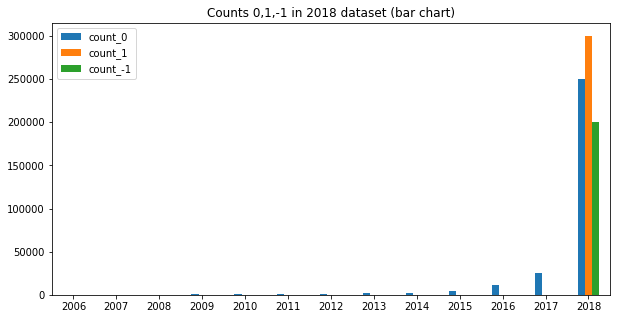

In [4]:
plot_binary_col(df_2018_count, minus_one = True, title = 'Counts 0,1,-1 in 2018 dataset (bar chart)')

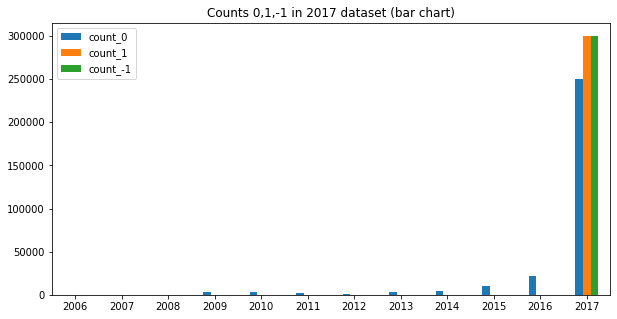

In [5]:
plot_binary_col(df_2017_count, minus_one = True, title = 'Counts 0,1,-1 in 2017 dataset (bar chart)')

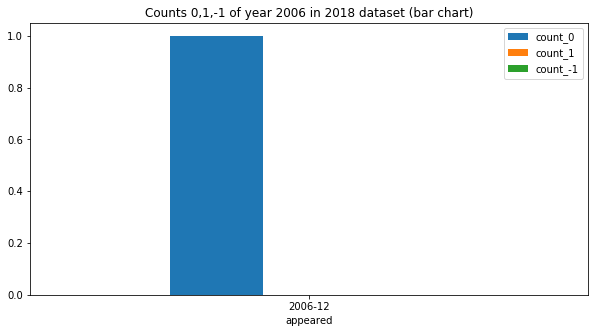

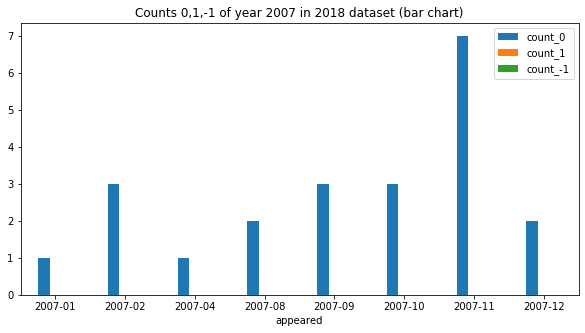

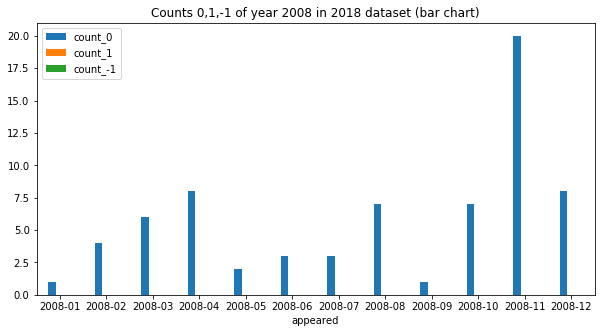

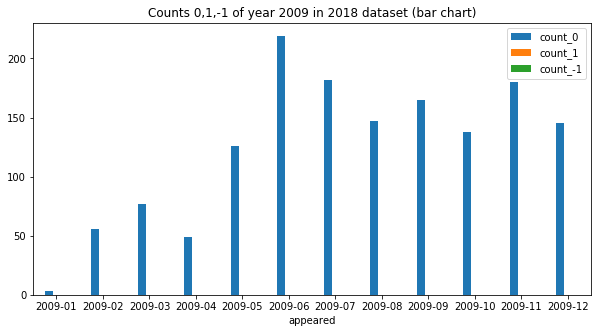

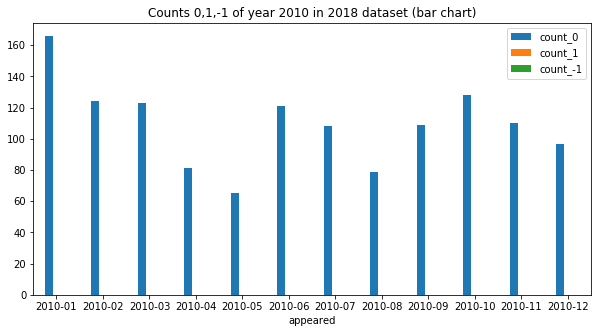

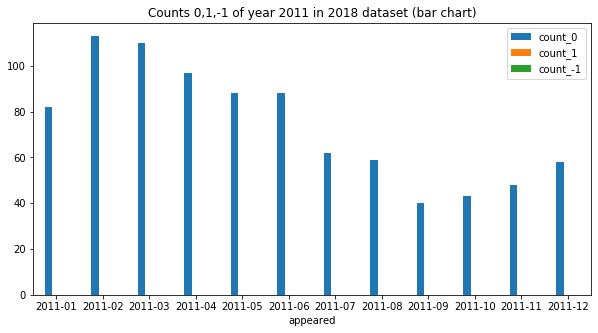

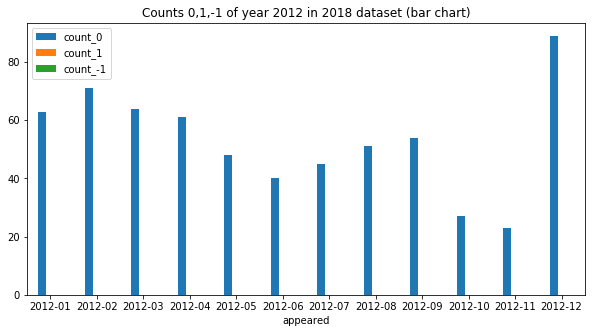

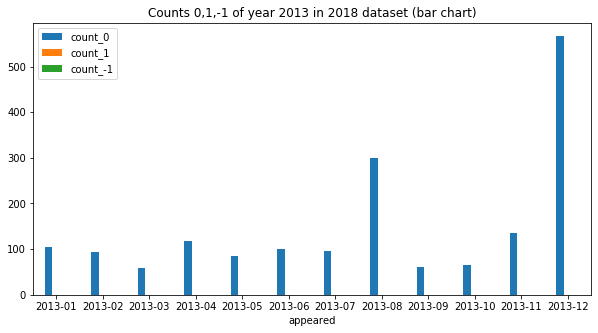

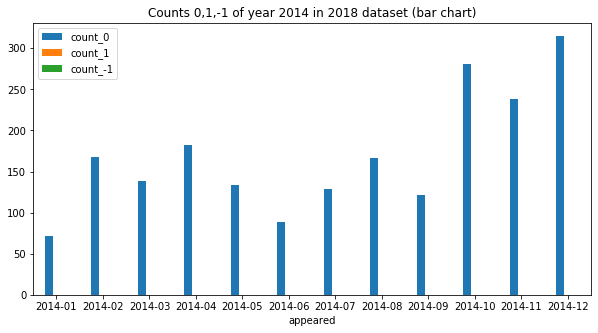

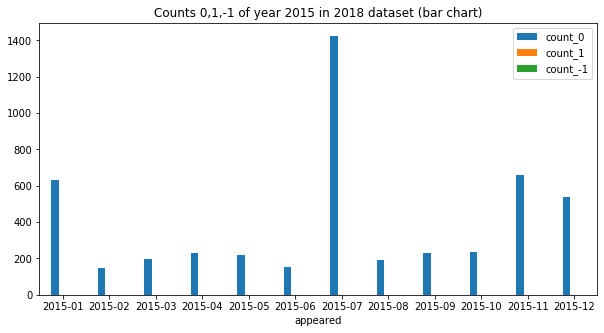

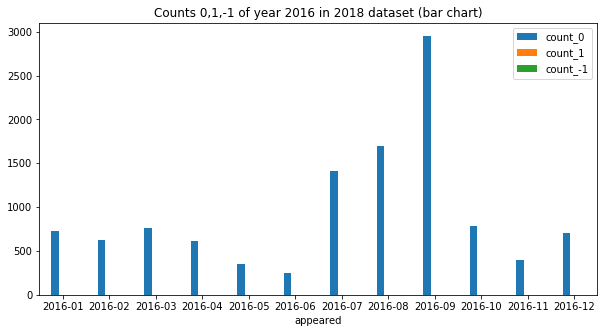

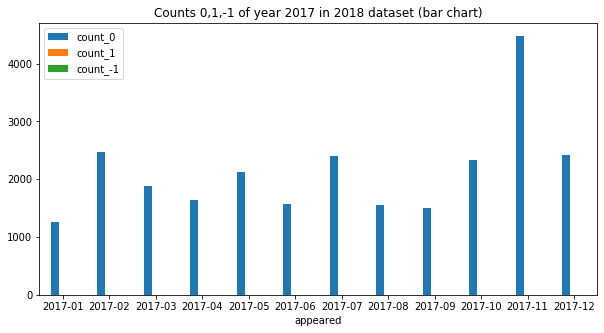

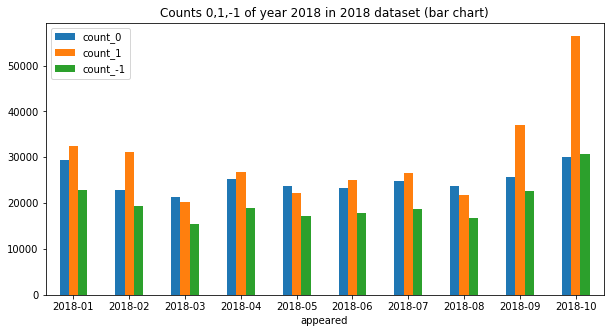

In [6]:
dataset = 2018
for year in range(2006, dataset + 1):
    plot_binary_col(df_2018_count, minus_one = True, year = year, title = 'Counts 0,1,-1 of year {} in {} dataset (bar chart)'.format(year,dataset))

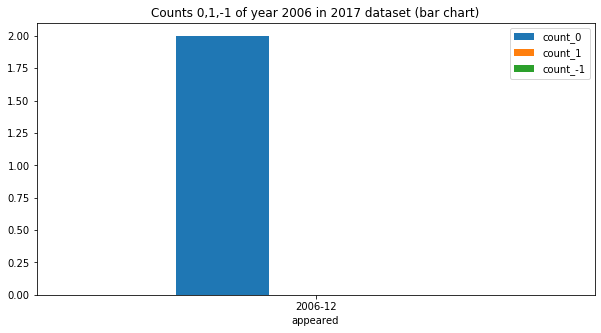

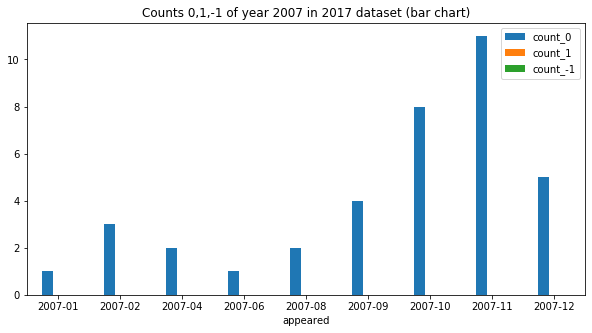

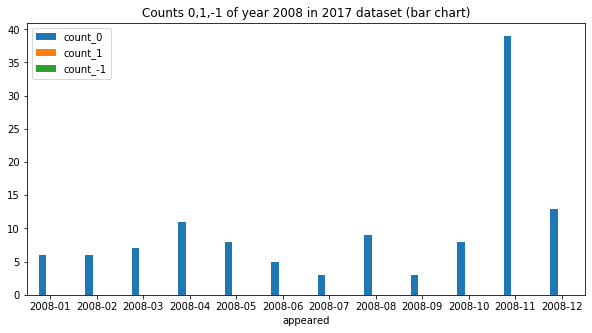

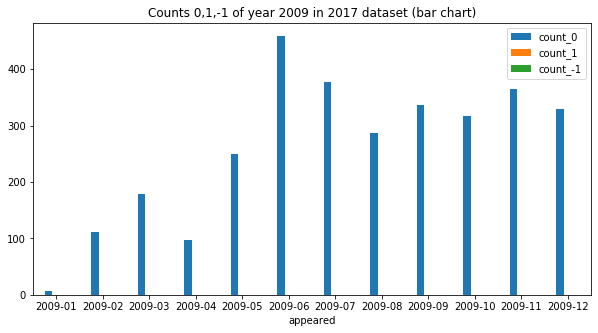

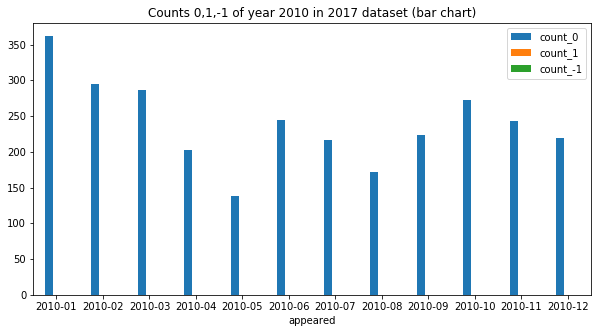

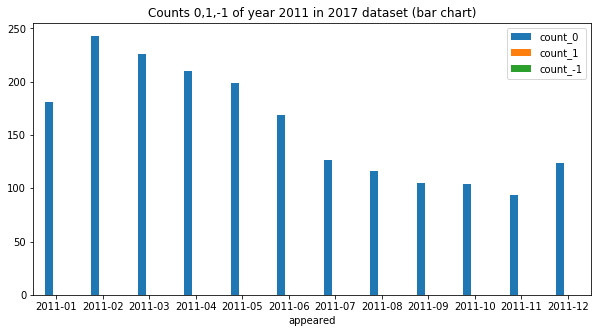

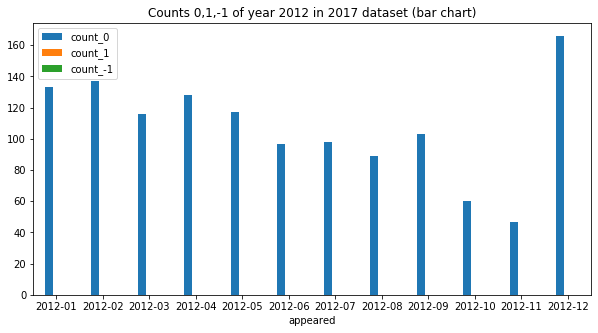

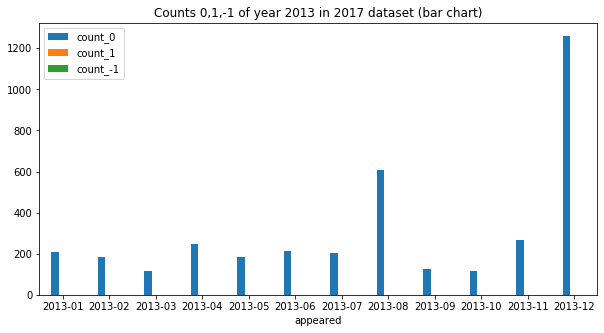

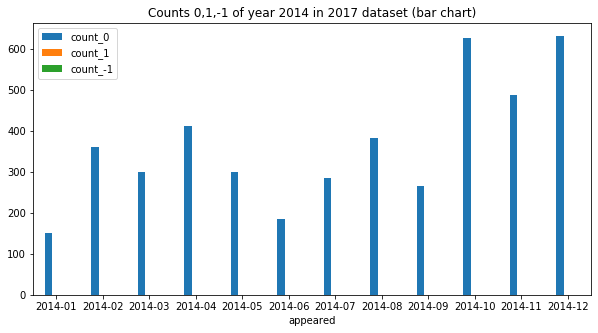

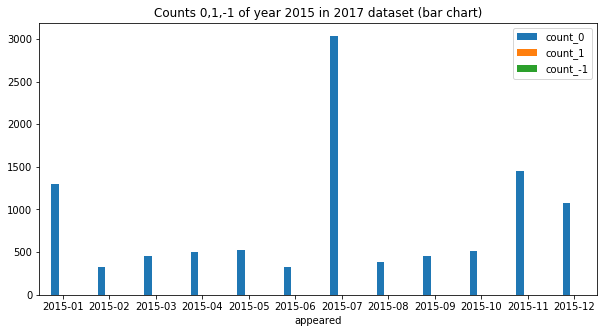

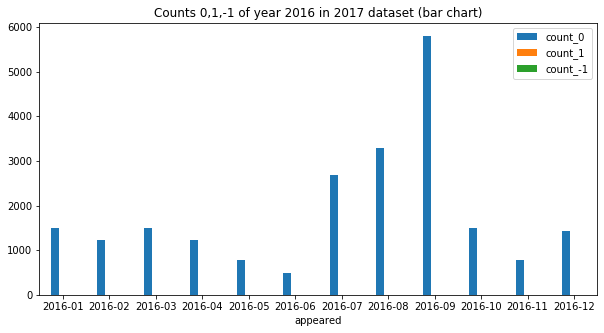

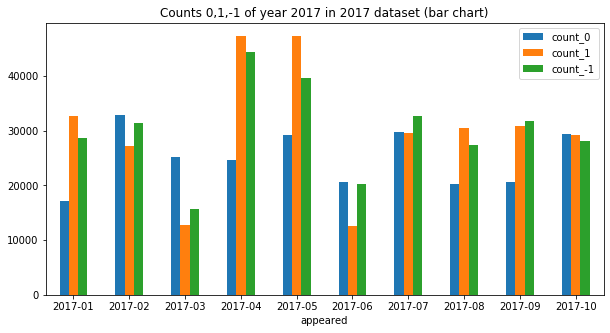

In [7]:
dataset = 2017
for year in range(2006, dataset + 1):
    plot_binary_col(df_2017_count, minus_one = True, year = year, title = 'Counts 0,1,-1 of year {} in {} dataset (bar chart)'.format(year,dataset))

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

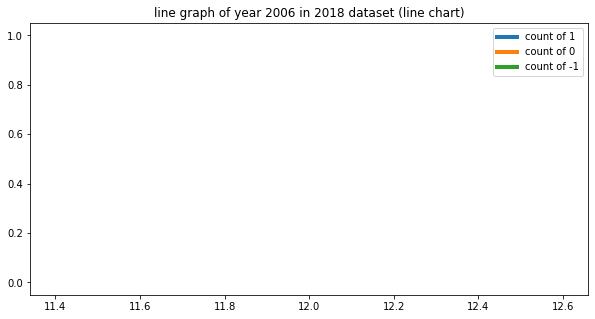

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

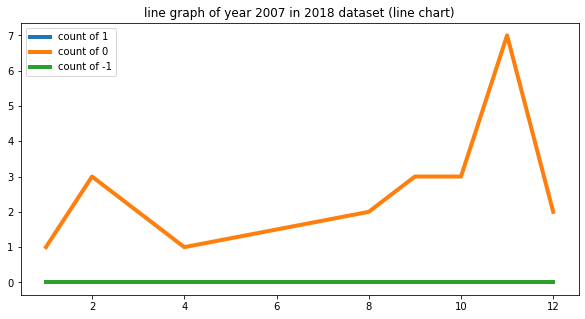

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

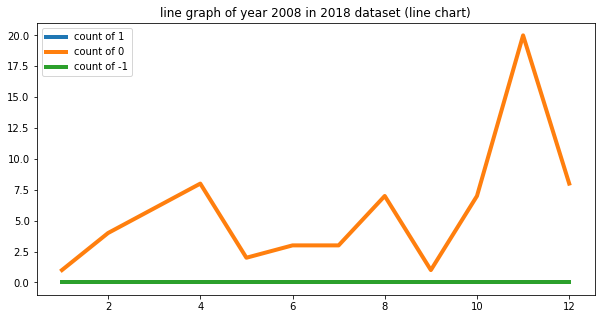

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

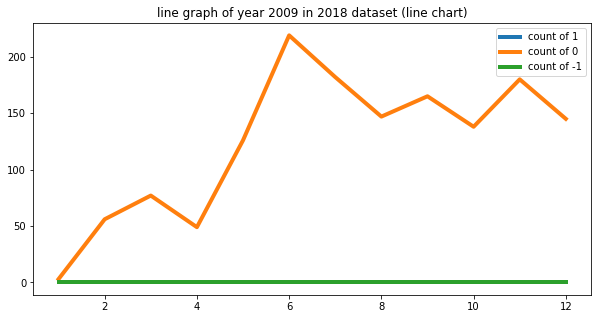

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

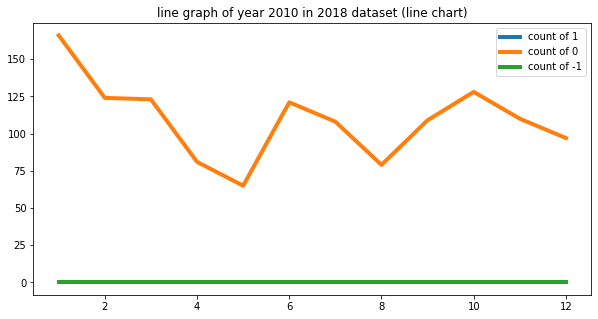

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

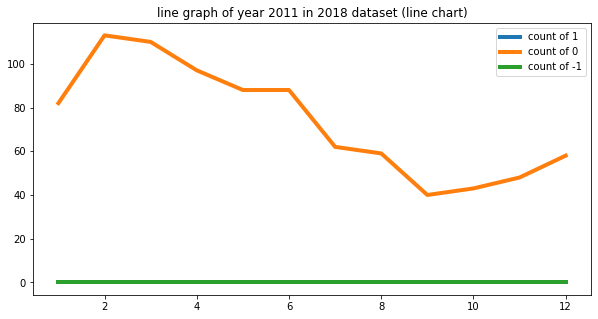

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

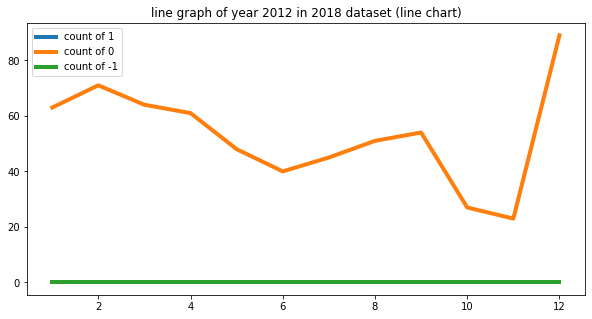

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

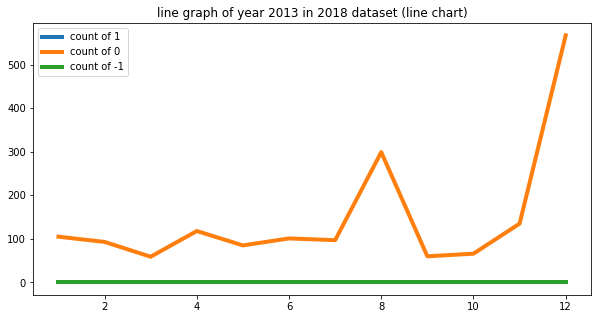

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

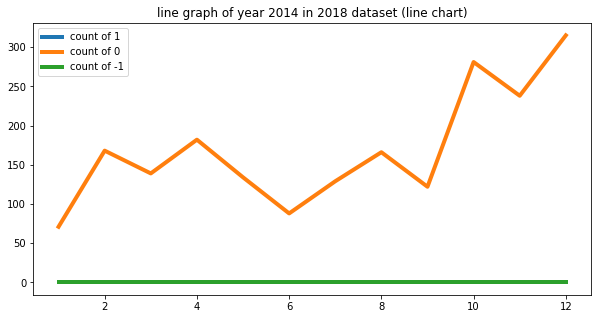

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

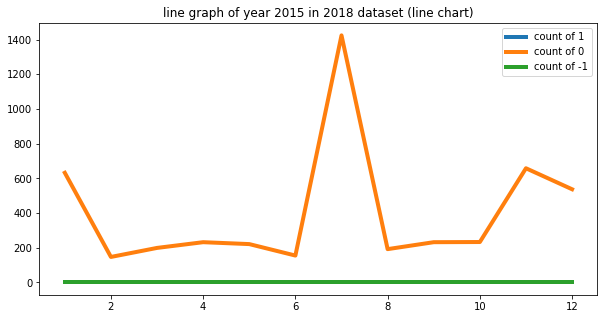

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

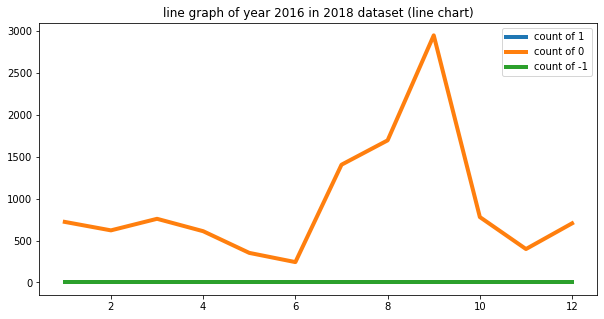

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

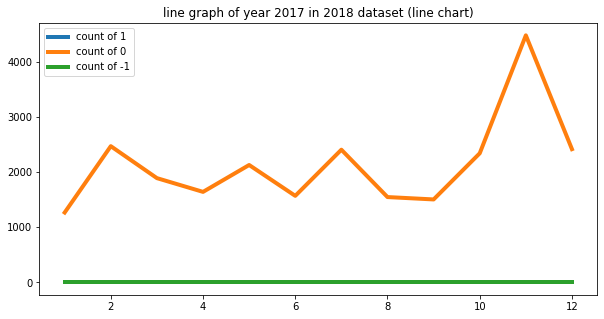

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

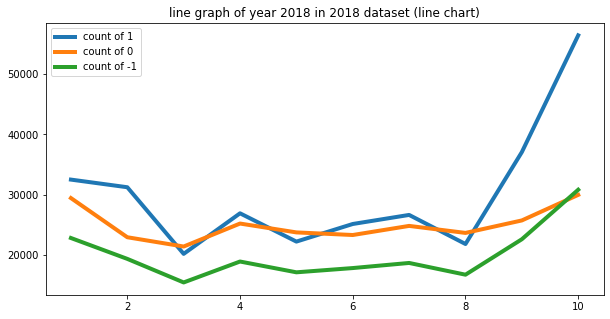

<Figure size 720x360 with 0 Axes>

In [8]:
dataset = 2018
for year in range(2006, dataset + 1):
    plot_line_graph(df_2018_count,year = year,title = 'line graph of year {} in {} dataset (line chart)'.format(year,dataset))

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

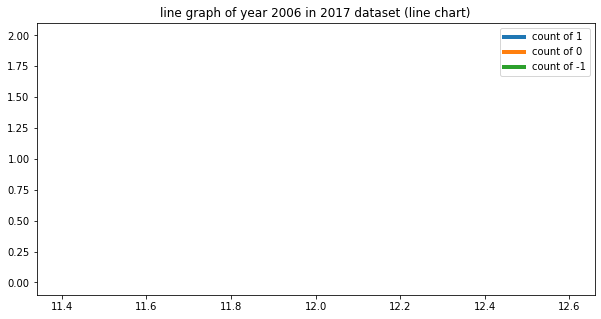

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

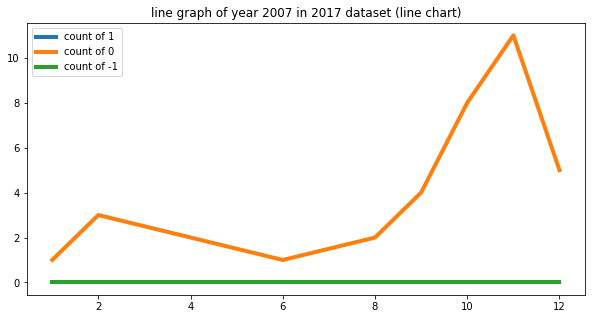

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

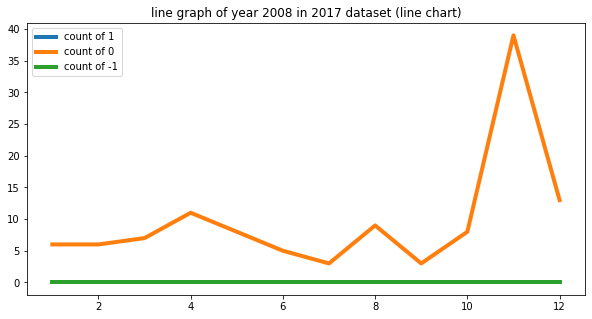

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

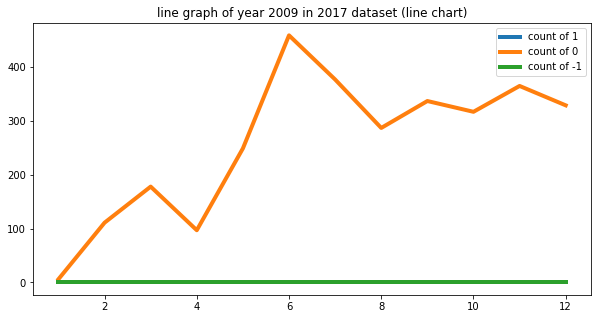

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

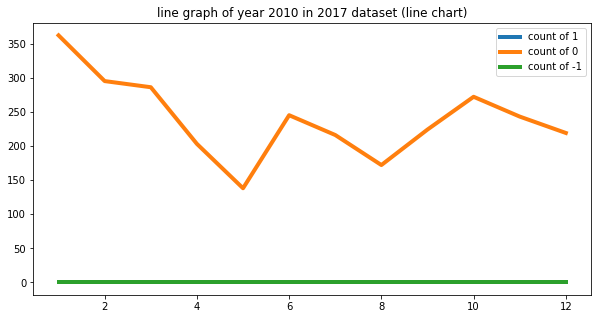

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

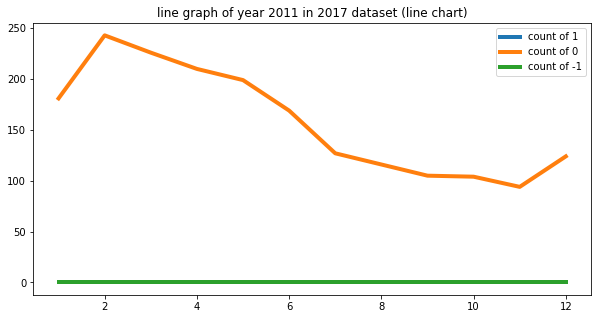

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

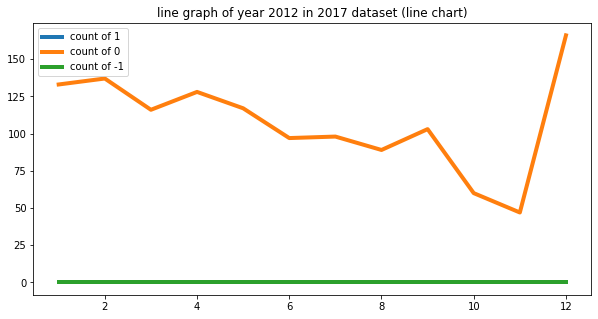

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

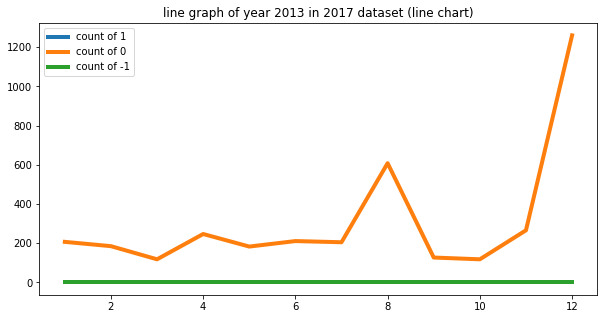

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

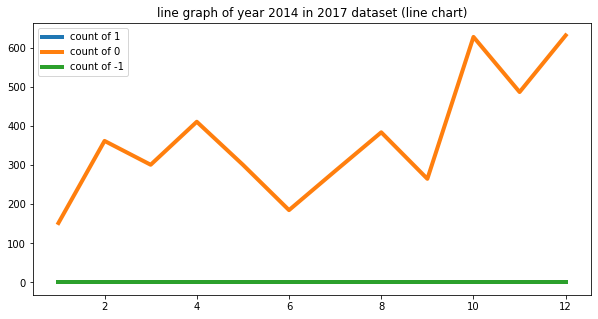

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

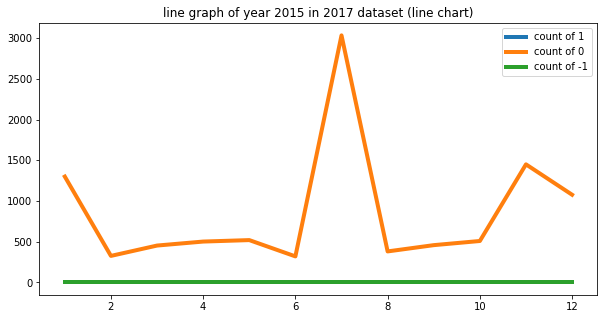

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

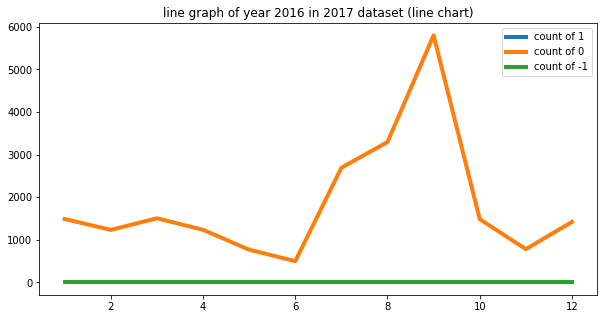

C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\czhao\anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

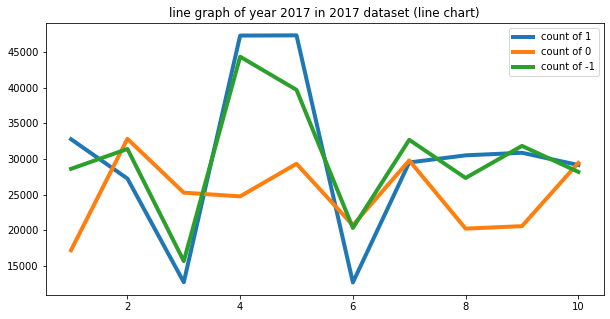

<Figure size 720x360 with 0 Axes>

In [9]:
dataset = 2017
for year in range(2006, dataset + 1):
    plot_line_graph(df_2017_count,year = year, title = 'line graph of year {} in {} dataset (line chart)'.format(year,dataset))

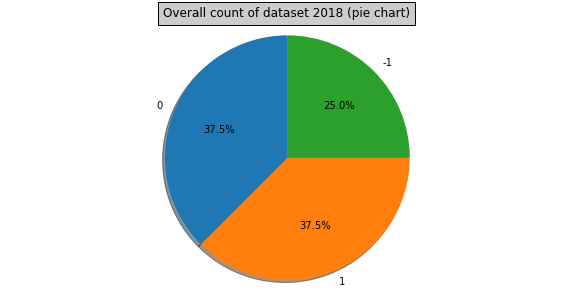

In [10]:
plot_pie_chart(df_2018_count, title = 'Overall count of dataset 2018 (pie chart)')

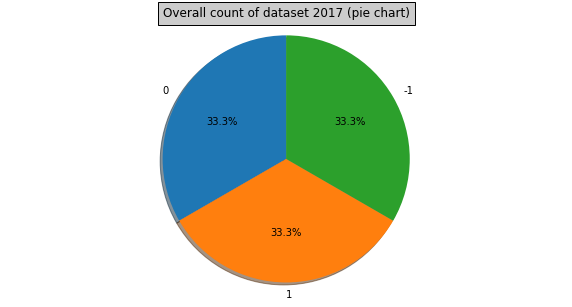

In [11]:
plot_pie_chart(df_2017_count, title = 'Overall count of dataset 2017 (pie chart)')

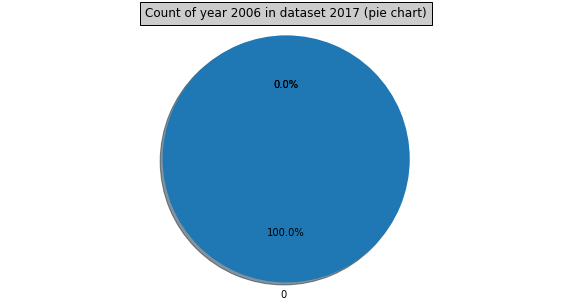

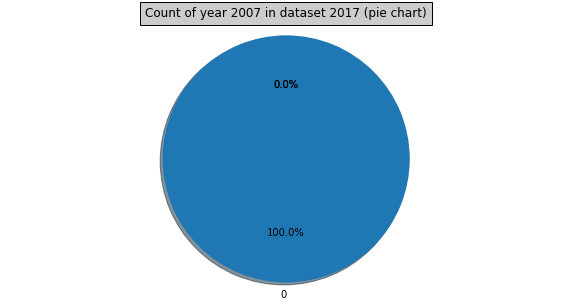

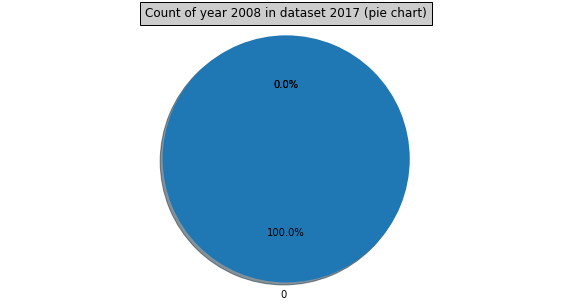

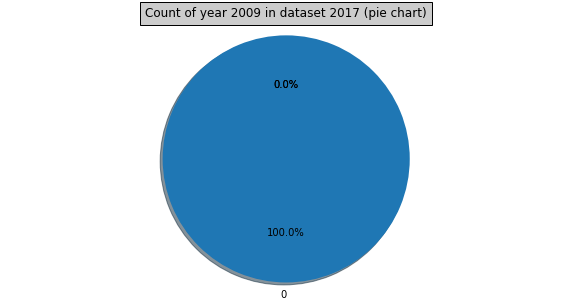

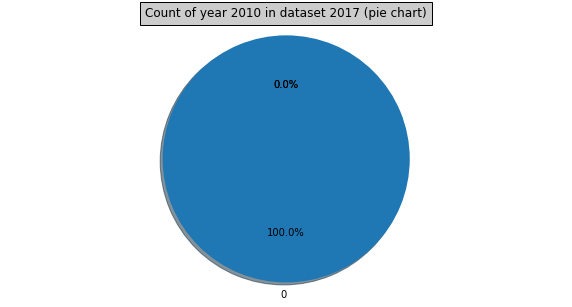

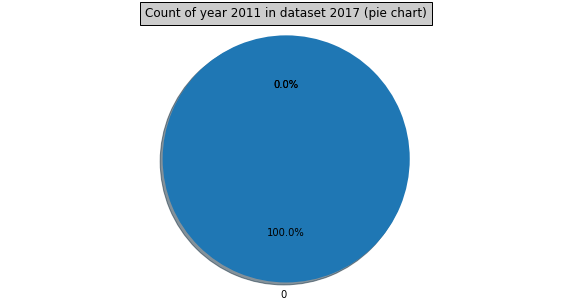

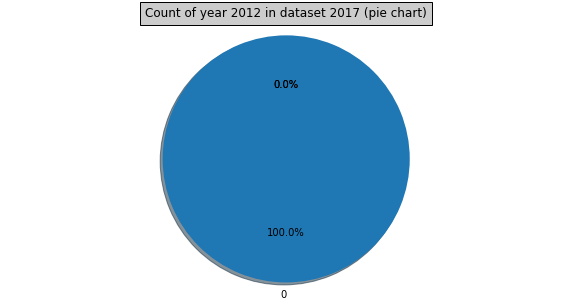

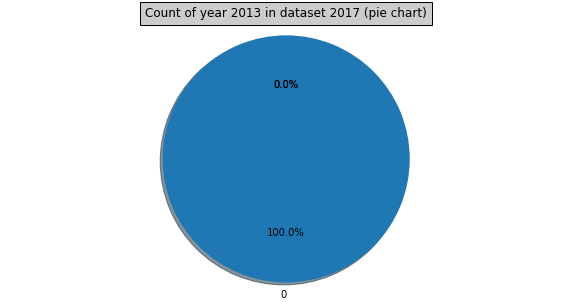

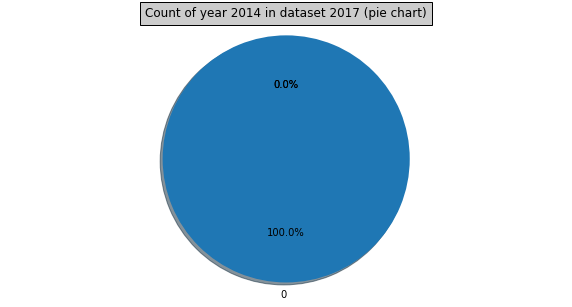

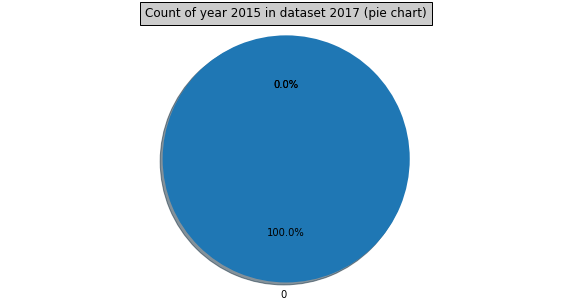

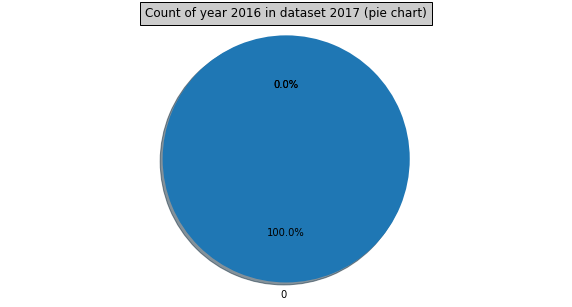

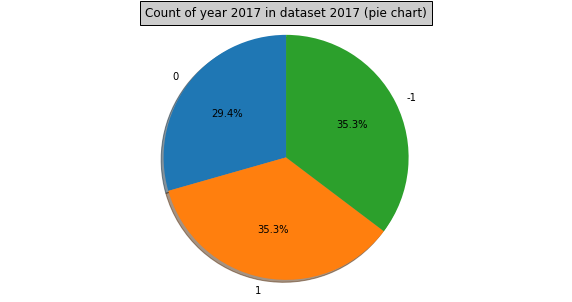

In [12]:
dataset = 2017
for year in range(2006, dataset + 1):
    plot_pie_chart(df_2017_count, year = year, title = 'Count of year {} in dataset {} (pie chart)'.format(year, dataset))

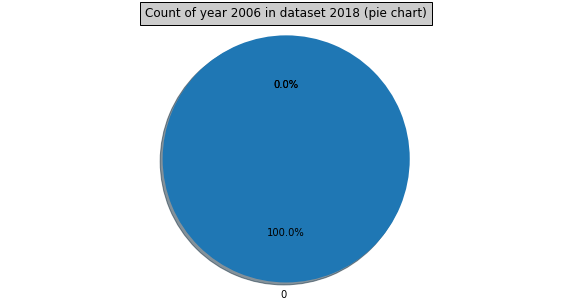

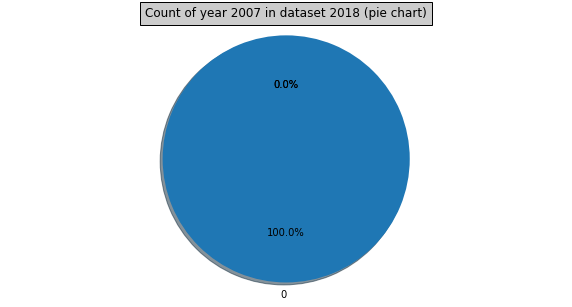

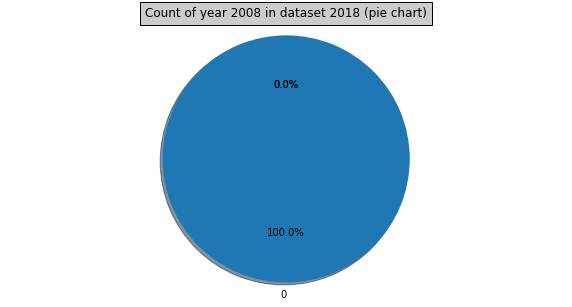

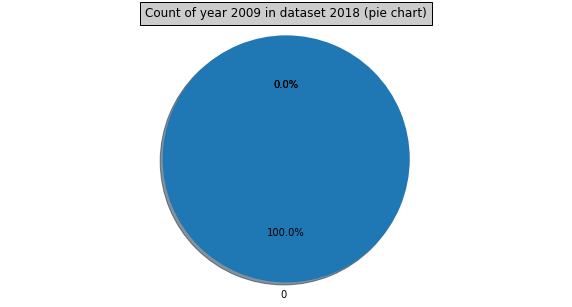

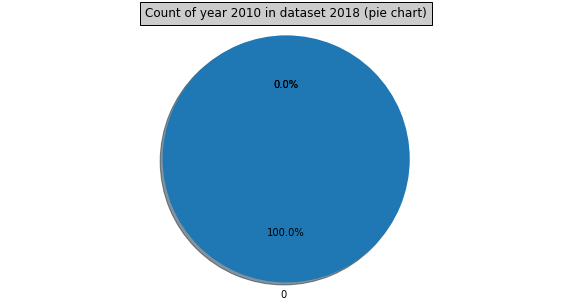

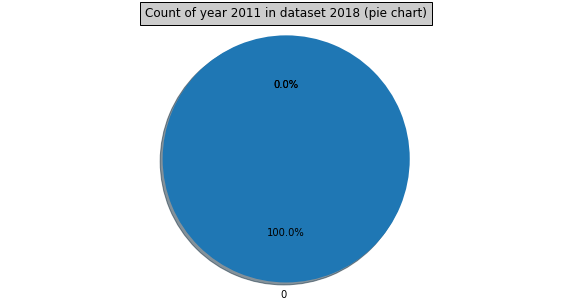

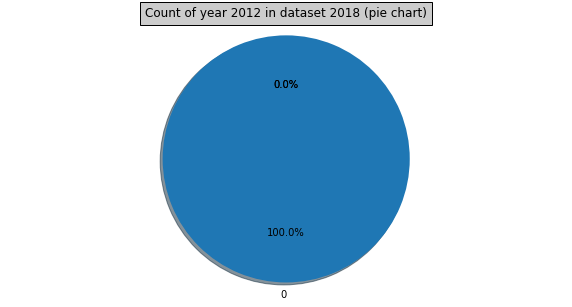

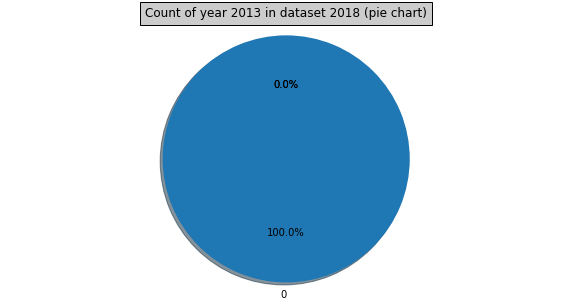

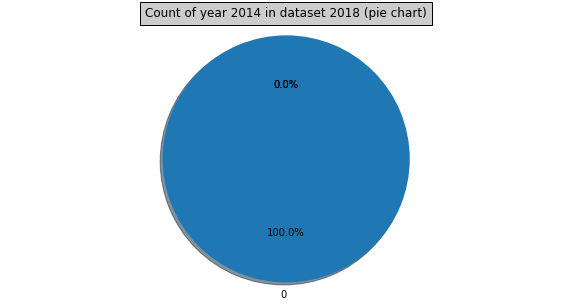

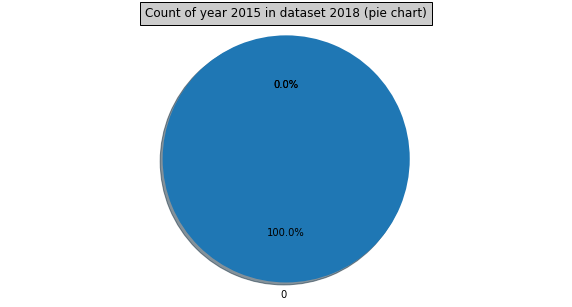

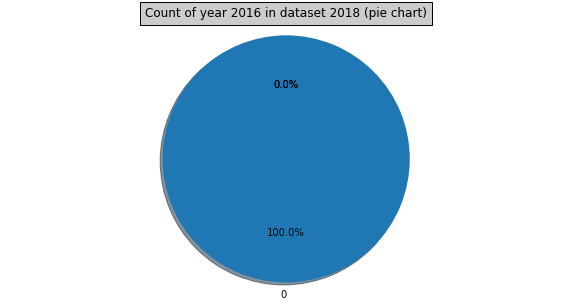

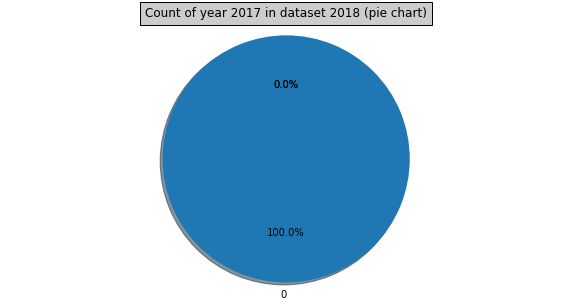

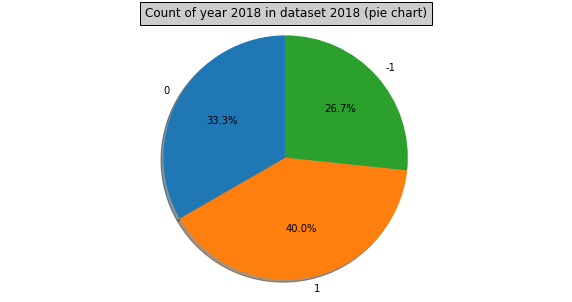

In [13]:
dataset = 2018
for year in range(2006, dataset + 1):
    plot_pie_chart(df_2018_count, year = year, title = 'Count of year {} in dataset {} (pie chart)'.format(year, dataset))